# 04 - K-Means clustering
This notebook performs K-Means clustering on the governance data set. It assumes the data was cleaned and placed in the cache by the "Explore the Governance Data Set" notebook.

This notebook is based on the steps from this article on medium. https://medium.com/@rohithramesh1991/unsupervised-text-clustering-using-natural-language-processing-nlp-1a8bc18b048d


---
## Dependencies and Imports

Here we import the libraries we need to perform our analysis.

In [3]:
import re
import sys
from pathlib import Path
print("python=={}".format(re.sub(r'\s.*', '', sys.version)))

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import __version__ as sklearn__version__
print(f"scikit-learn=={sklearn__version__}")

import pandas as pd
print(f"pandas=={pd.__version__}")
ROW    = 0
COLUMN = 1
STRING = 'string'
OBJECT = 'object'
NUMBER = 'number'
CATEGORY = 'category'
INTEGER = 'integer'
UNSIGNED = 'unsigned'
FLOAT = 'float'

import matplotlib.pyplot as plt
from matplotlib import __version__ as matplotlib__version__
print(f"matplotlib=={matplotlib__version__}")

import seaborn as sns
print(f"seaborn=={sns.__version__}")

python==3.9.13
scikit-learn==1.2.2
pandas==2.0.2
matplotlib==3.7.1
seaborn==0.12.2


---
## Apply K-Means to the Governance Data Set
We applied LSA to the subset _duurzaamheidsvisie_ (DV) documents from the governance data set. Next step is applying K-Means clustering.

### Step 1  Load the DV Documents from the Governance Data

In [4]:
CACHE_DIR = '../cache/Governance'

GLOB_DV = CACHE_DIR + '/GM????DV??.txt'

# take a glob and make it iterable. We cannot use globs as objects, since these get
# "exhausted" when you iterate over them.
# https://stackoverflow.com/questions/51108256/how-to-take-a-pathname-string-with-wildcards-and-resolve-the-glob-with-pathlib
def expand_glob(glob):
    p = Path(glob)
    return Path(p.parent).expanduser().glob(p.name)

print(f"'Duurzaamheidsvisie' documents = {GLOB_DV}")

DOCUMENT_BODY = 'body'

def load_corpus_as_dataframe(glob):
    df = pd.DataFrame(data   =[file.read_text() for file in expand_glob(glob)],
                      index  =[file.stem        for file in expand_glob(glob)],
                      columns=[DOCUMENT_BODY])
    df[DOCUMENT_BODY] = df[DOCUMENT_BODY].astype(STRING)

    return df


'Duurzaamheidsvisie' documents = ../cache/Governance/GM????DV??.txt


In [5]:
# the caller is expected to select the right column from their data frame and
# pass it in as a series.
def compose_document_term_matrix_by_count(series, min_df=1, max_df=0.85):
    vectorizer = CountVectorizer(min_df=min_df)
    dt_matrix  = vectorizer.fit_transform(series)
    dictionary = vectorizer.get_feature_names_out()

    return pd.DataFrame(index=series.index, columns=dictionary, data=dt_matrix.toarray()), \
           dictionary


In [6]:
def perform_lsa(dt_matrix, dictionary, n_components=2):
    svd = TruncatedSVD(n_components=n_components)
    lsa = svd.fit_transform(dt_matrix)
    topics = [f"topic {n}" for n in range(lsa.shape[1])]

    return pd.DataFrame(index=dt_matrix.index, data=lsa, columns=topics), \
           pd.DataFrame(index=topics, data=svd.components_, columns=dictionary).T

In [7]:
def n_most_significant(topic, n_terms, encoding_matrix):
    df = encoding_matrix[topic]
    return df.iloc[df.abs().argsort()][::-1][:n_terms].to_frame()

In [8]:
# the caller is expected to select the right column from their data frame and
# pass it in as a series.
def compose_document_term_matrix(series, min_df=1, max_df=0.85, sublinear_tf=False):
    vectorizer = TfidfVectorizer(min_df=min_df, sublinear_tf=sublinear_tf)
    dt_matrix  = vectorizer.fit_transform(series)
    dictionary = vectorizer.get_feature_names_out()

    return pd.DataFrame(index=series.index, columns=dictionary, data=dt_matrix.toarray()), \
           dictionary

In [9]:
corpus = load_corpus_as_dataframe(GLOB_DV)
corpus


,body
GM0003DV02,duurzaamheidsbeleid Appingedam duurzaamheidsbe...
GM0005DV01,colofon gemeente bedum bezoekadres Schoolstraa...
GM0007DV01,Milieubeleidsplan vaststellen gemeenteraad bel...
GM0009DV01,inhoud duurzaamheidsvisie februari inhoud inho...
GM0034DV01,verseonnr dagmail december raad gemeente almer...
...,...
GM1945DV01,duurzaamheidsprogramma gemeente groesbeek duur...
GM1955DV01,milieuprogramma gemeente Montferland vaststell...
GM1955DV02,notitie ruimtelijk inpassing stroomopwekking z...
GM1955DV03,energietransitienota duurzaam energie achterho...


In [10]:
document_term_matrix, dictionary = compose_document_term_matrix(corpus[DOCUMENT_BODY], min_df=15, max_df=0.85, sublinear_tf=True)
document_term_matrix

,aanbested,aanbesteding,aanbestedingen,aanbestedingsbeleid,aanbestedingstraject,aanbeveling,aanbieden,aanbieder,aanbieding,aanbod,...,zuinig,zuiniger,zuiveren,zuivering,zullen,zwaar,zwart,zwembad,zwerfafval,zwerfvuil
GM0003DV02,0.000000,0.011433,0.000000,0.000000,0.000000,0.036249,0.028349,0.0,0.0,0.011697,...,0.030663,0.0,0.000000,0.000000,0.035804,0.000000,0.000000,0.000000,0.000000,0.00000
GM0005DV01,0.000000,0.013772,0.000000,0.000000,0.000000,0.000000,0.012232,0.0,0.0,0.000000,...,0.023966,0.0,0.000000,0.000000,0.031126,0.000000,0.000000,0.000000,0.086930,0.00000
GM0007DV01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016741,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.035747,0.014843,0.000000,0.000000,0.035296,0.04721
GM0009DV01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016989,0.0,0.0,0.033133,...,0.000000,0.0,0.000000,0.000000,0.040968,0.000000,0.000000,0.031519,0.000000,0.00000
GM0034DV01,0.000000,0.014623,0.026919,0.000000,0.000000,0.000000,0.012988,0.0,0.0,0.000000,...,0.015030,0.0,0.000000,0.030255,0.041087,0.033014,0.034339,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GM1945DV01,0.000000,0.021913,0.016904,0.025425,0.043833,0.000000,0.013810,0.0,0.0,0.000000,...,0.015981,0.0,0.031787,0.000000,0.022829,0.020732,0.000000,0.000000,0.000000,0.00000
GM1955DV01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021732,0.0,0.0,0.014785,...,0.000000,0.0,0.000000,0.000000,0.034107,0.045982,0.000000,0.000000,0.000000,0.00000
GM1955DV02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.024242,...,0.024354,0.0,0.000000,0.000000,0.026020,0.000000,0.055641,0.000000,0.000000,0.00000
GM1955DV03,0.000000,0.000000,0.000000,0.000000,0.000000,0.079871,0.012903,0.0,0.0,0.014863,...,0.000000,0.0,0.000000,0.000000,0.024586,0.000000,0.000000,0.000000,0.000000,0.00000


### LSA toepassen

In [11]:
lsa = TruncatedSVD(n_components=5)
lsa_matrix = lsa.fit_transform(document_term_matrix)
print(lsa_matrix)

[[ 6.16286306e-01 -7.19935258e-02 -6.43090149e-05  2.59944072e-02
   1.19021019e-01]
 [ 5.69297469e-01  3.38789840e-01 -8.80828921e-02 -2.91232507e-02
   1.25935465e-02]
 [ 5.93379525e-01  3.49803219e-01  2.36348418e-02 -4.15914922e-02
   9.71602819e-02]
 ...
 [ 4.95181881e-01 -1.03059244e-01  2.58066930e-02  1.12268280e-02
  -3.66440008e-03]
 [ 5.68573707e-01 -8.55103557e-02 -1.22243111e-01  6.93475187e-02
  -4.68067540e-02]
 [ 5.86589015e-01  3.62946165e-01 -1.50268008e-01 -8.69954225e-02
   6.52276473e-03]]


## Training the model

Bronnen: 
https://medium.com/@rohithramesh1991/unsupervised-text-clustering-using-natural-language-processing-nlp-1a8bc18b048d
https://campus.datacamp.com/courses/cluster-analysis-in-python/k-means-clustering-3?ex=1

In [10]:
Sum_of_squared_distances = []
K = range(1,100)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(lsa_matrix)
    Sum_of_squared_distances.append(km.inertia_)

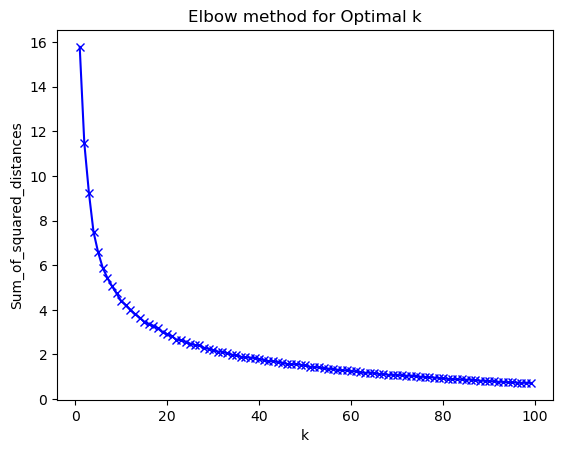

In [11]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow method for Optimal k')
plt.show()

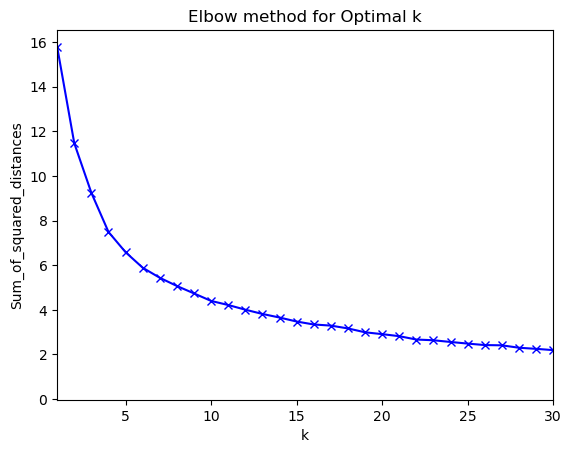

In [12]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow method for Optimal k')
plt.xlim(1, 30)
#plt.ylim(150, 170)
plt.show()

### Making sense of the clusters

C:\Users\jurri\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\jurri\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


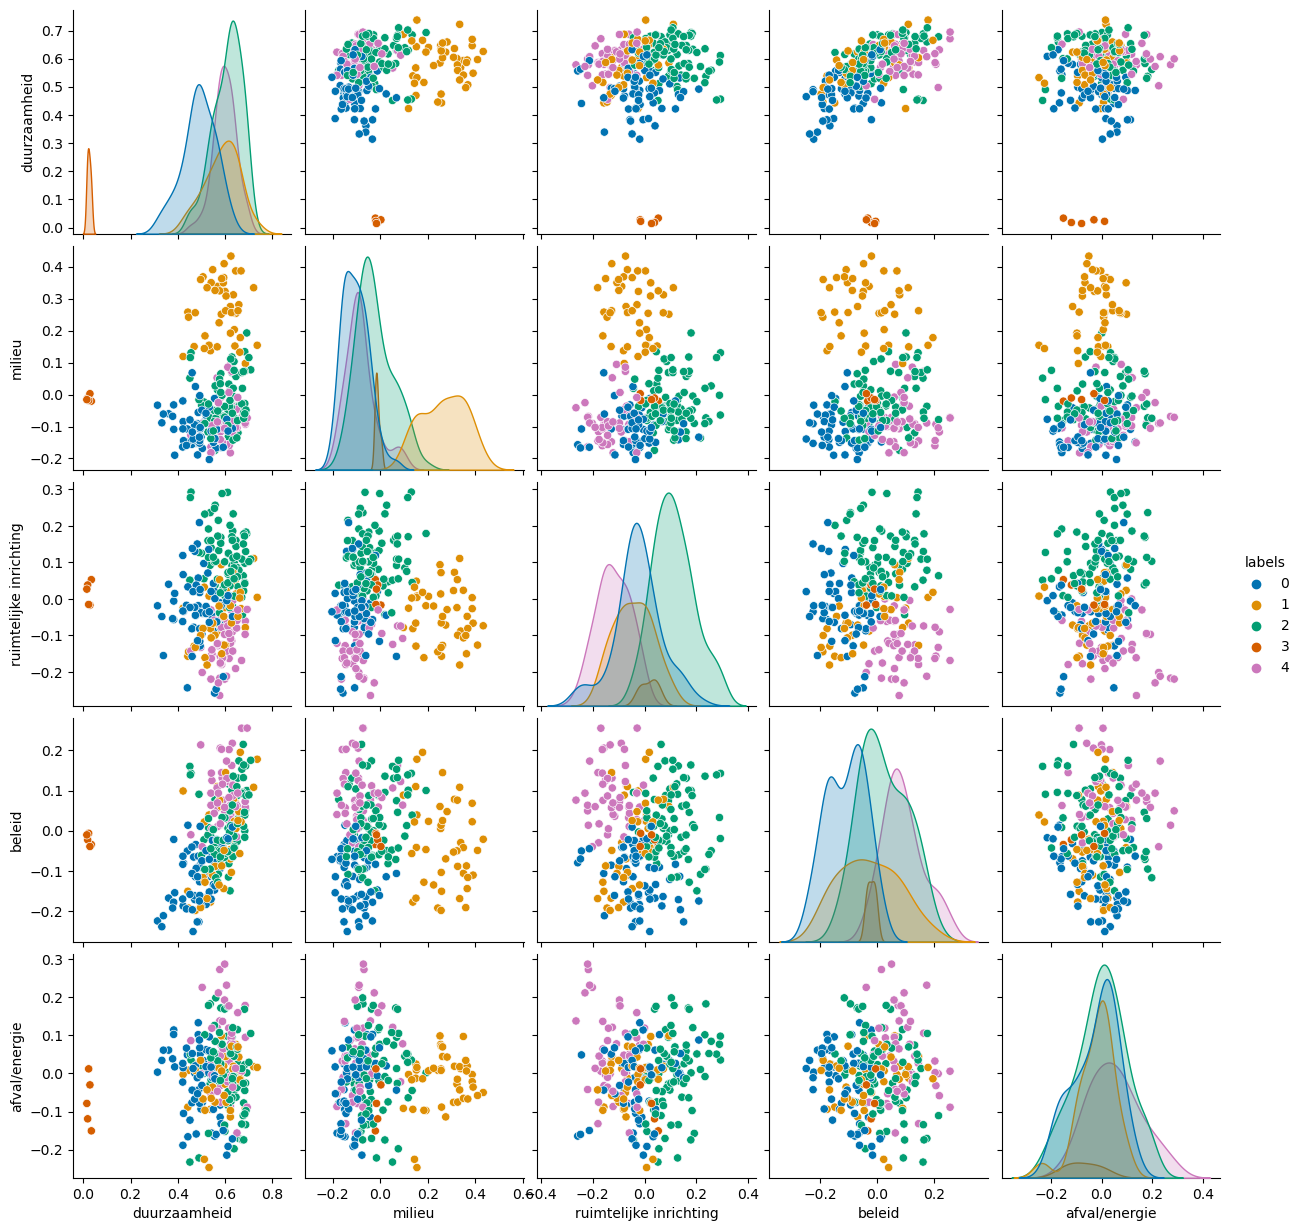

In [14]:
# K-means clustering met k=5
kmeans = KMeans(n_clusters=5)
kmeans.fit(lsa_matrix)

topic_names = ["duurzaamheid","milieu","ruimtelijke inrichting","beleid","afval/energie"]

# Scatterplots maken van de clusters per topic
topics = pd.DataFrame(lsa_matrix, columns=topic_names, index=corpus.index)
topics['labels'] = kmeans.labels_
fig = sns.pairplot(topics, hue='labels', palette="colorblind")

# Centroids verkrijgen en toevoegen aan de pairplot
centroids = pd.DataFrame(kmeans.cluster_centers_[:, 0:5], columns=topic_names)
fig.data = centroids
fig.map_offdiag(plt.scatter, color="black", marker="*")


###  Silhouette score 
The silhouette score is a metric provided by scikit-learn that measures the quality of clustering results based on the average distance between samples within clusters and the average distance between samples in different clusters. It takes into account both the cohesion (how close samples are to each other within the same cluster) and the separation (how far samples are from samples in other clusters). The range is from -1 to 1.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

In [15]:
silhouette_avg = silhouette_score(lsa_matrix, kmeans.labels_)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.2662820726868849


The score is close to 0 this indicates that the clusters are overlapping or ambiguous.

In [ ]:
silhouette_scores = []
for k in range(2, 15 + 1):
    kmeans_model = KMeans(n_clusters=k)
    labels = kmeans.fit(lsa_matrix)
    silhouette_avg = silhouette_score(lsa_matrix, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

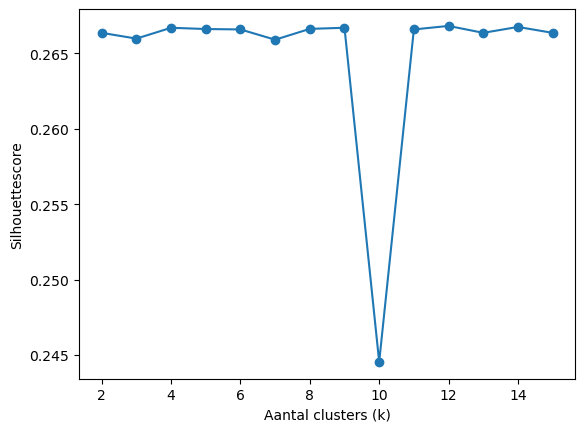

In [17]:
plt.plot(range(2, 15 + 1), silhouette_scores, marker='o')
plt.xlabel('Aantal clusters (k)')
plt.ylabel('Silhouettescore')
plt.show()

In [20]:
topics.to_parquet("../data/Governance/Kmeans_clusters.parquet")